In [1]:
import spacy 
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
train_corpus = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))
test_corpus = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'))

print(f"Train size: {len(train_corpus.data)}")
print(f"Test size: {len(test_corpus.data)}")

Train size: 11314
Test size: 7532


In [3]:
print(f"Labels: {train_corpus.target_names}")
print(f"\nLabel encoded: {train_corpus.target}")

print(f"\nExample Article: {train_corpus.data[0]}")

Labels: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Label encoded: [7 4 4 ... 3 1 8]

Example Article: I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import plotly.express as px

px.histogram(train_corpus.target, color=train_corpus.target)

In [8]:
%%time
nlp = spacy.load('en_core_web_sm')

def custom_tokenizer(doc):
    with nlp.disable_pipes('ner', 'parser'):
        doc = nlp(doc)
        return [token.lemma_ for token in doc if token.is_stop == False and token.is_punct == False and token.is_alpha and not token.is_space]

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

X_train = vectorizer.fit_transform(train_corpus.data)
Y_train = train_corpus.target

X_test = vectorizer.transform(test_corpus.data)
Y_test = test_corpus.target

CPU times: total: 1min 45s
Wall time: 6min


In [28]:
X_train.toarray()

MemoryError: Unable to allocate 4.05 GiB for an array with shape (11314, 48019) and data type float64

In [93]:
# save the model to a joblib file
import joblib

# Save your object with joblib
joblib.dump(vectorizer, 'vectorizer.joblib')

# Load your object
vectorizer = joblib.load('vectorizer.joblib')


PicklingError: Can't pickle <function custom_tokenizer at 0x000001E2A4FD8FE0>: it's not the same object as __main__.custom_tokenizer

In [21]:
%%time

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

clf = MultinomialNB()
clf.fit(X_train, Y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_acc = accuracy_score(Y_train, y_train_pred)
test_acc = accuracy_score(Y_test, y_test_pred)

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.8525720346473395
Test accuracy: 0.6714020180562932
CPU times: total: 15.6 ms
Wall time: 79.8 ms


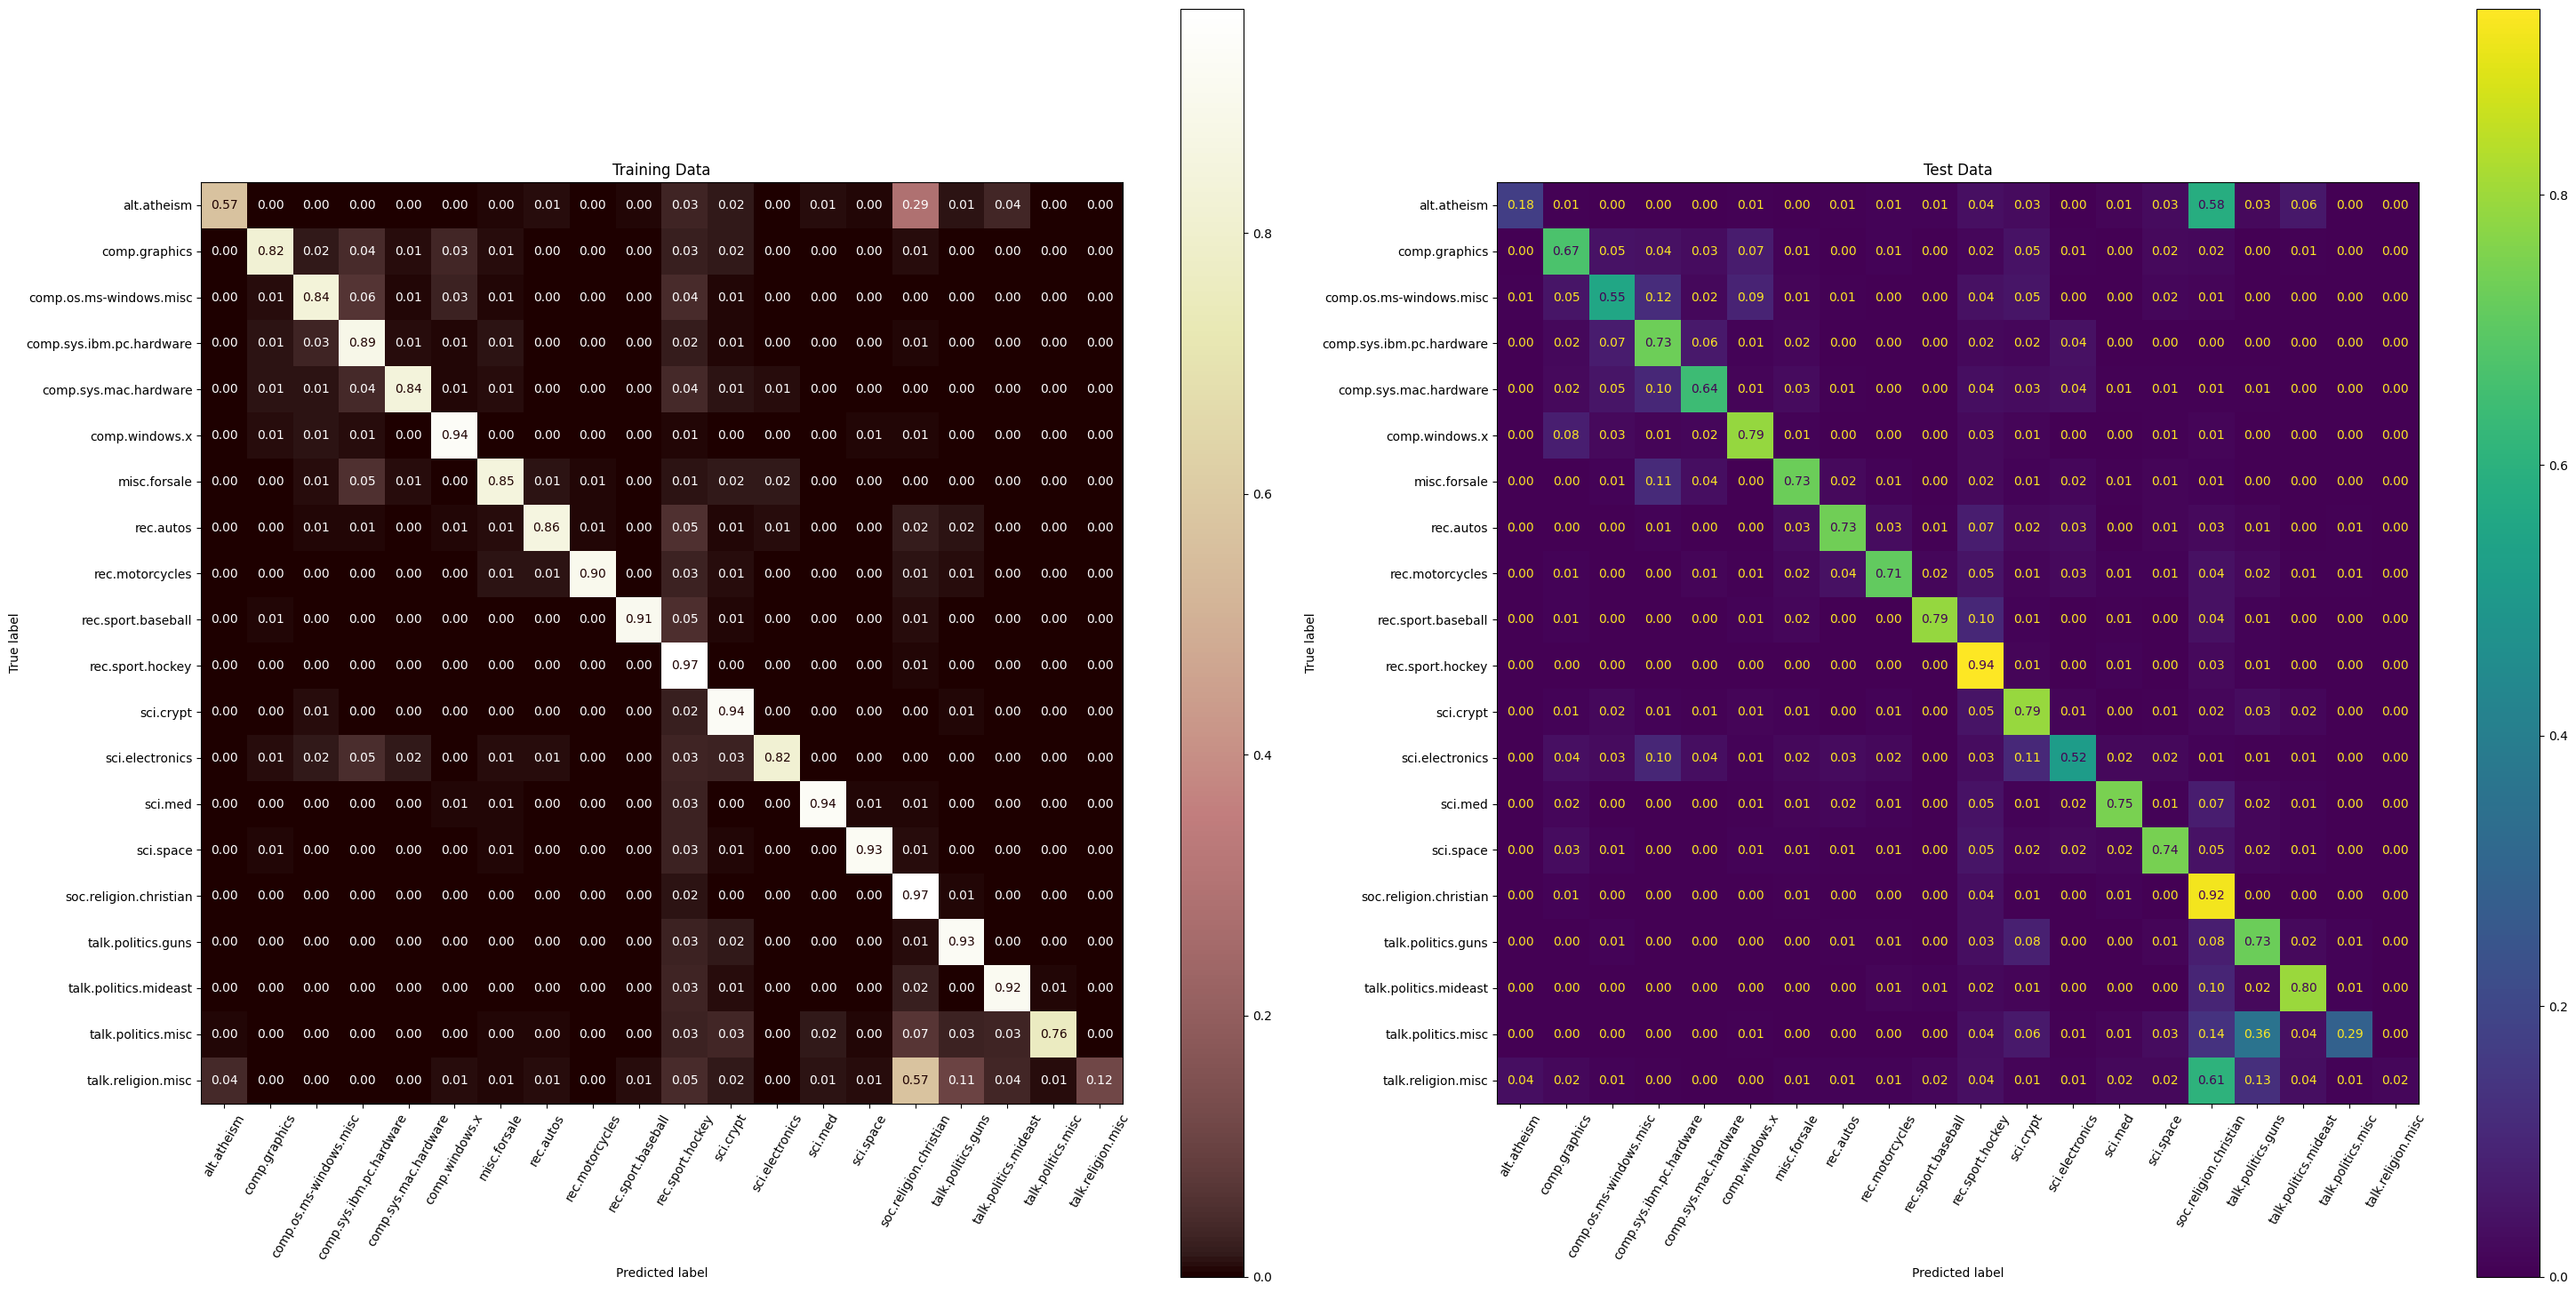

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(30, 15))


# Plot confusion matrix for training data
ConfusionMatrixDisplay.from_estimator(clf, X_train, Y_train, ax=axes[0], normalize='true', display_labels=train_corpus.target_names,values_format='.2f', cmap='pink')

# Plot confusion matrix for test data
ConfusionMatrixDisplay.from_estimator(clf, X_test, Y_test, ax=axes[1], normalize='true', cmap='viridis', display_labels=test_corpus.target_names,values_format='.2f')

# Rotate x-axis tick labels on the first subplot
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title('Training Data')

# Rotate y-axis tick labels on the second subplot
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title('Test Data')


# Display the plot
plt.tight_layout()
plt.show()

In [61]:
from sklearn.metrics import classification_report

train_name = [Y_train, Y_test]
test_rs = [y_train_pred, y_test_pred]
target_name = [train_corpus, test_corpus]

for idx, i in enumerate(zip(train_name, test_rs, target_name)):
    print(classification_report(i[0], i[1], target_names=i[2].target_names))
    if idx ==0:
        print("***"*50)
    else:
        pass

                          precision    recall  f1-score   support

             alt.atheism       0.93      0.57      0.71       480
           comp.graphics       0.90      0.82      0.86       584
 comp.os.ms-windows.misc       0.87      0.84      0.85       591
comp.sys.ibm.pc.hardware       0.76      0.89      0.82       590
   comp.sys.mac.hardware       0.94      0.84      0.89       578
          comp.windows.x       0.89      0.94      0.92       593
            misc.forsale       0.90      0.85      0.87       585
               rec.autos       0.93      0.86      0.89       594
         rec.motorcycles       0.96      0.90      0.93       598
      rec.sport.baseball       0.98      0.91      0.94       597
        rec.sport.hockey       0.65      0.97      0.78       600
               sci.crypt       0.83      0.94      0.88       595
         sci.electronics       0.93      0.82      0.87       591
                 sci.med       0.96      0.94      0.95       594
         

In [87]:
Article = str(input("Enter an article: "))

Article = vectorizer.transform([Article])

idx = clf.predict(Article)[0]

pred_article = train_corpus.target_names[idx]
confidence = clf.predict_proba(Article)[0][idx]

print(f"Article belongs to {pred_article} with {confidence*100:.2f}% confidence")

Article belongs to rec.sport.baseball with 40.47% confidence
